In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
!pip install --upgrade imutils


  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=388b33b721bc0e9d9b8f99b9f83b7d412369db6f606cebc683ead67f022eeb63
  Stored in directory: /home/azureuser/.cache/pip/wheels/f5/0c/3a/61b992f7aa85de40f339e6d4970d91dddb103dd0ad6c5d58f2
Successfully built imutils


In [4]:
# Importing libraries

from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from tqdm import tqdm
import csv

In [5]:
# defining hyperparams

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 30
NUM_FEATURES = 2048

In [10]:
data_dir = "Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2"

In [79]:
csv_data = []
for dir_name in os.listdir(data_dir):
    full_dir = os.path.join(data_dir, dir_name)
    for file in os.listdir(full_dir)[40:50]:
        csv_data.append([file, dir_name])
        # print("Video Name = {}, tag={}".format(file, dir_name))

In [80]:

header = ['video_name', 'tag']

with open('test.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(csv_data)

In [81]:
# data preparation

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 160
Total videos for testing: 40


,video_name,tag
127,Normal_Videos_024_x264.mp4,Normal
67,Explosion028_x264.mp4,Explosion
141,Normal_Videos_070_x264.mp4,Normal
35,Burglary036_x264.mp4,Burglary
157,Normal_Videos_251_x264.mp4,Normal
103,Fighting025_x264.mp4,Fighting
104,Fighting026_x264.mp4,Fighting
32,Burglary033_x264.mp4,Burglary
159,Normal_Videos_310_x264.mp4,Normal
156,Normal_Videos_248_x264.mp4,Normal


In [82]:
# extracting frames until a max. frame count is reached
# if video frame count < max. frame -> pad video with zeros


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [83]:
# Extracting features from 

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [84]:
# one hot encoding
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['', 'Burglary', 'Explosion', 'Fighting', 'Normal']


In [85]:
# preparing videos
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    clases_names = labels
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in tqdm(enumerate(video_paths)):
        # Gather all its frames and add a batch dimension.
        path = os.path.join(clases_names[idx], path)
        full_video_path = os.path.join(root_dir, path)
        frames = load_video(full_video_path)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[1]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_featutes.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, data_dir)
test_data, test_labels = prepare_all_videos(test_df, data_dir)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

160it [13:08,  4.93s/it]
40it [07:53, 11.84s/it]

Frame features in train set: (160, 30, 2048)
Frame masks in train set: (160, 30)


In [86]:
# Model

# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 1.6773 - accuracy: 0.2679
Epoch 00001: val_loss improved from inf to 2.03074, saving model to video_classifier
4/4 [==============================] - 3s 726ms/step - loss: 1.6773 - accuracy: 0.2679 - val_loss: 2.0307 - val_accuracy: 0.0000e+00
Epoch 2/10
3/4 [=====================>........] - ETA: 0s - loss: 1.5261 - accuracy: 0.3750
Epoch 00002: val_loss did not improve from 2.03074
4/4 [==============================] - 0s 41ms/step - loss: 1.5685 - accuracy: 0.3571 - val_loss: 2.0957 - val_accuracy: 0.0000e+00
Epoch 3/10
3/4 [=====================>........] - ETA: 0s - loss: 1.4826 - accuracy: 0.3958
Epoch 00003: val_loss did not improve from 2.03074
4/4 [==============================] - 0s 36ms/step - loss: 1.5025 - accuracy: 0.3571 - val_loss: 2.2706 - val_accuracy: 0.0000e+00
Epoch 4/10
3/4 [=====================>........] - ETA: 0s - loss: 1.5506 - accuracy: 0.3750
Epoch 00004: val_loss did not improve from 2.030

In [87]:

# Saving the model
model_json = sequence_model.to_json()
with open("inceptiov3-gru.json", "w") as json_file:
    json_file.write(model_json)
sequence_model.save_weights('inceptiov3-gru.h5')
print('model saved success')

model saved success


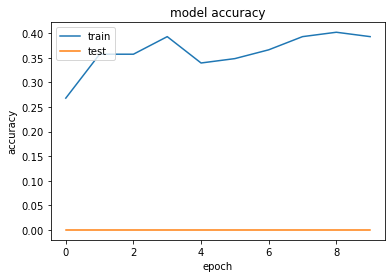

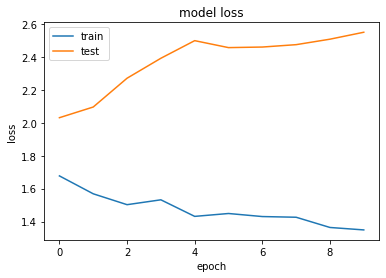

In [88]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
# Testing


def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    # frames = load_video(os.path.join("test", path))
    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


#  visualization

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: Youtube_Videos/Test Video.mp4
  Burglary: 30.09%
  Explosion: 28.02%
  : 18.57%
  Normal: 13.76%
  Fighting:  9.56%



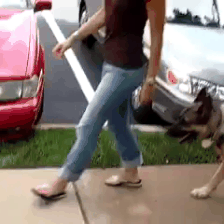

In [94]:
test_video = "Youtube_Videos/Test Video.mp4"
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)

In [96]:
# creating confusion matrix

from sklearn.metrics import confusion_matrix
import itertools    

# test_data, test_labels

In [98]:
model_prediction = sequence_model.predict(test_data)
prediction = np.argmax(model_prediction, axis=1)

In [114]:
prediction_final = prediction - 1
prediction_final

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [115]:
test_labels_ = test_labels.flatten()
test_labels_ -= 1
test_labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [116]:
cm = confusion_matrix(y_true=test_labels, y_pred=prediction)

In [117]:
cm

array([[10,  0,  0,  0],
       [10,  0,  0,  0],
       [10,  0,  0,  0],
       [ 9,  1,  0,  0]])

In [110]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [118]:
classes= ['Burglary', 'Explosion', 'Fighting', 'Normal']
classes

['Burglary', 'Explosion', 'Fighting', 'Normal']

Confusion matrix, without normalization
[[10  0  0  0]
 [10  0  0  0]
 [10  0  0  0]
 [ 9  1  0  0]]


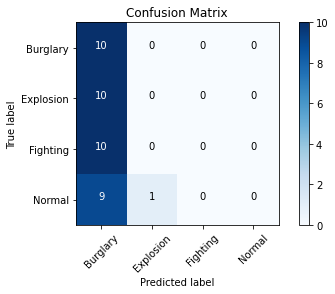

In [119]:
plot_confusion_matrix(cm, classes,  title='Confusion Matrix', cmap=plt.cm.Blues)